# Comparación de palabras iguales en poemas con emociones diferentes.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from nltk.tokenize import word_tokenize
import nltk
import we_to_signal as wes

[nltk_data] Downloading package punkt to /home/ulises/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ulises/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#Con los poemas separados, los metemos en un diccionario de dataframes
import os

data_path = "data/"
emotion_list = ["anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise", "trust"]

json_files = sorted([pos_json for pos_json in os.listdir(data_path) if pos_json.endswith('.json')])
json_files.remove('Poems.json')
json_files.remove('missing.json')

em_poems = {}
for e in emotion_list:
    f = open(data_path+e+".json")
    df_ = pd.DataFrame(json.load(f))
    em_poems[e] = df_
em_poems["anger"]

,poem,id
0,i do know this it's nothing i can hold\nlast ...,10
1,the fear o' hell's a hangman's whip\nto haud t...,18
2,but since i laid a hand thereon\nand found a h...,88
3,falsely i pointed to sum in text\nseriously he...,99
4,i'll wear my jealous reflection\njuice of lemo...,125
...,...,...
2461,new snow on a leaf\nlike granulated sugar\nmak...,93124
2462,new earth and old earth\na trio of guardians\n...,93138
2463,destructions despair\nconstructions hope toge...,93217
2464,hot dry summers will\nbake paint right off the...,93226


In [3]:
#Carga de embeddings
from gensim.models import Word2Vec
from gensim.models import FastText

emotion_list = ["anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise", "trust"]

poems_w2v = {}
poems_fst = {}

for e in emotion_list:
    w2v_lines = Word2Vec.load("embeddings_poems/w2v_model_"+e)
    fst_lines = FastText.load("embeddings_poems/fst_model_"+e)
    poems_w2v[e] = w2v_lines
    poems_fst[e] = fst_lines

In [4]:
emotion_a = "anger"
emotion_b = "anticipation"

mw2v_a = poems_w2v[emotion_a]
mfst_a = poems_fst[emotion_a]

mw2v_b = poems_w2v[emotion_b]
mfst_b = poems_fst[emotion_b]

In [5]:
def common_word(model_a,model_b)->list:
    """
    Create a list of common word in two gensim models.

    Parameters
    -------------
    model_a: Gensim model (fst or w2v).
    model_b: Gensim model (fst or w2v).

    Returns
    --------------
    list: List with common words between the models.
    """
    model_a_dict = model_a.wv.key_to_index
    model_b_dict = model_b.wv.key_to_index

    common_words = []
    for key in list(model_a_dict.keys()):
        if key in model_b_dict:
            common_words.append(key)
    
    return common_words

common_words_w2v = common_word(mw2v_a,mw2v_b)
common_words_fst = common_word(mfst_a,mfst_b)

In [6]:
def get_vectors(words:list,model)->list:
    """
    Calculate the embeddings of a list of strings gived a model.

    Parameters
    ------------
    words: List with strings.
    model: gensim model(fst or w2v)
    
    Returns
    ------------
    list: List with tuples of [word,vector].
    """

    vectors = []
    for word in words:
        vectors.append((word,model.wv.get_vector(word)))
    return vectors

In [7]:
def build_words_vectors_data(common_words:list,model_a,model_b)->pd.DataFrame:
    """
    Creates a Dataframe with columns [words, embbeding_model_a, embbeding_model_b]
    
    Parameters
    ------------
    common_words: list with common word between models.
    model_a: gensim model (fastext or w2v).
    model_b: gensim model (fastext or w2v).
    """

    data = {}
    data["words"] = common_words.copy()
    data["embbeding_model_a"] = []
    data["embbeding_model_b"] = []

    for word in common_words:
        data["embbeding_model_a"].append(model_a.wv.get_vector(word,norm=True))
        data["embbeding_model_b"].append(model_b.wv.get_vector(word,norm=True))

    return pd.DataFrame(data)

In [8]:
data_w2v = build_words_vectors_data(common_words_w2v,mw2v_a,mw2v_b)
data_fst = build_words_vectors_data(common_words_fst,mfst_a,mfst_b)

display(data_w2v)
display(data_fst)

,words,embbeding_model_a,embbeding_model_b
0,the,"[-0.074571356, 0.09888577, -0.035351947, 0.058...","[-0.12992264, 0.09067258, 0.0016633858, 0.0660..."
1,and,"[-0.076016836, 0.09836932, -0.0359653, 0.05484...","[-0.09529541, 0.14158711, 0.007732343, -0.0349..."
2,of,"[-0.07567521, 0.09813196, -0.037018374, 0.0551...","[-0.103375435, 0.124761075, -0.009955226, 0.01..."
3,a,"[-0.07517576, 0.09953175, -0.03721849, 0.05452...","[-0.10672734, 0.12793517, 0.005556323, 0.00644..."
4,to,"[-0.0747832, 0.09769986, -0.036672354, 0.05156...","[-0.041993607, 0.20082001, 0.0009315059, -0.09..."
...,...,...,...
8265,martyrs,"[-0.11708717, 0.18000051, -0.07979874, 0.10236...","[-0.09172351, 0.028397692, -0.036259986, -0.01..."
8266,elation,"[-0.056189828, 0.09017971, 0.060131565, 0.1171...","[0.043908708, 0.030624766, -0.10485483, 0.0380..."
8267,afternoons,"[0.060429826, -0.12160156, 0.07337983, -0.1498...","[-0.10714079, 0.15676244, 0.06014968, 0.108518..."
8268,gibberish,"[-0.009315444, 0.05983702, -0.09838189, 0.1613...","[-0.022979211, 0.18154301, -0.033790972, -0.00..."


,words,embbeding_model_a,embbeding_model_b
0,the,"[0.05892307, 0.038402352, -0.075489864, 0.0635...","[0.043330193, -0.010277707, -0.16763657, -0.00..."
1,and,"[0.059186235, 0.039017975, -0.073899955, 0.064...","[0.013457333, 0.028681222, -0.09165401, -0.027..."
2,of,"[0.061216712, 0.039325263, -0.075887546, 0.063...","[-0.009552455, 0.03292888, -0.0690358, -0.0304..."
3,a,"[0.059903935, 0.038734823, -0.07522733, 0.0629...","[0.03983606, 0.010796906, -0.09718523, -0.0059..."
4,to,"[0.060684998, 0.03858779, -0.07509665, 0.06213...","[0.074966714, 0.01745066, -0.041270588, 0.0064..."
...,...,...,...
1755,fortunes,"[0.060194585, 0.038032826, -0.07509847, 0.0634...","[0.047516268, 0.010357625, -0.06097739, 0.0037..."
1756,release,"[0.061862584, 0.03776, -0.07397126, 0.06235046...","[0.06364246, 0.003003505, -0.052978072, 0.0139..."
1757,decide,"[0.059682563, 0.039320666, -0.07605457, 0.0621...","[0.054955315, 0.008287174, -0.05922585, 0.0076..."
1758,bridges,"[0.060322605, 0.038319036, -0.074086666, 0.063...","[0.03656169, 0.013152264, -0.066844985, -0.003..."


In [9]:
word = "bring"

word_data = data_w2v[data_w2v["words"]==word]
word_data

,words,embbeding_model_a,embbeding_model_b
339,bring,"[-0.0688656, 0.09416714, -0.03821187, 0.053954...","[-0.05977244, 0.16778417, 0.009542436, -0.0438..."


In [10]:
print(word_data["embbeding_model_a"].values)

[array([-0.0688656 ,  0.09416714, -0.03821187,  0.05395499, -0.01844637,
        -0.2211572 ,  0.07139511,  0.28029686, -0.08197512, -0.11862894,
        -0.03529203, -0.1844964 , -0.04797777,  0.1167135 ,  0.08020385,
        -0.06601369,  0.08363637, -0.07533801,  0.00131319, -0.1951293 ,
         0.1019508 ,  0.06257318,  0.11337823, -0.07108132,  0.00257333,
        -0.01600572, -0.10341936, -0.05314986, -0.14204891,  0.05522308,
         0.16569097, -0.03880035,  0.03558872, -0.11911778, -0.06649421,
         0.10201389,  0.05073204, -0.04951679, -0.10054959, -0.22217542,
         0.01045941, -0.09135779, -0.051673  ,  0.03244301,  0.10582011,
        -0.06917658, -0.1120397 , -0.04529528,  0.06246192,  0.07548869,
         0.04870709, -0.07880032, -0.01240519, -0.04002517, -0.04369382,
         0.05379791,  0.04440226, -0.03455228, -0.11280337,  0.01228787,
         0.08759329, -0.03583346,  0.00696939, -0.02195072, -0.10176867,
         0.19567388,  0.01146567,  0.15209161, -0.2

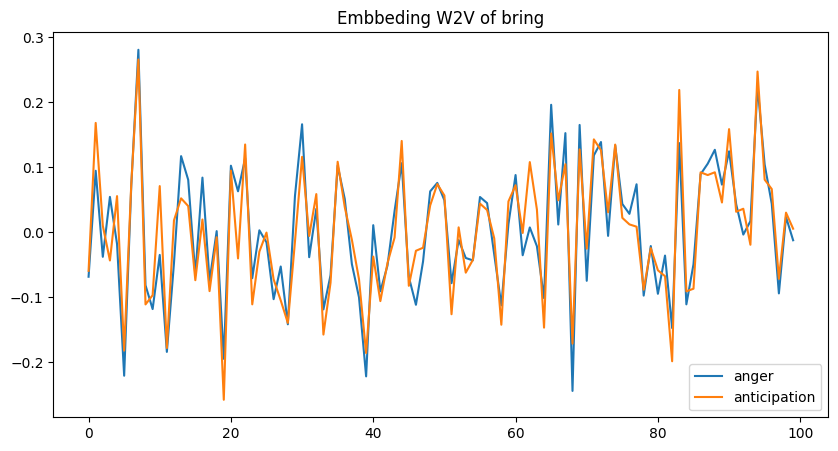

In [11]:
legend = [emotion_a,emotion_b]
plt.figure(figsize=(10,5))
plt.title("Embbeding W2V of "+word)
plt.plot(word_data["embbeding_model_a"].values[0])
plt.plot(word_data["embbeding_model_b"].values[0])
plt.legend(legend)

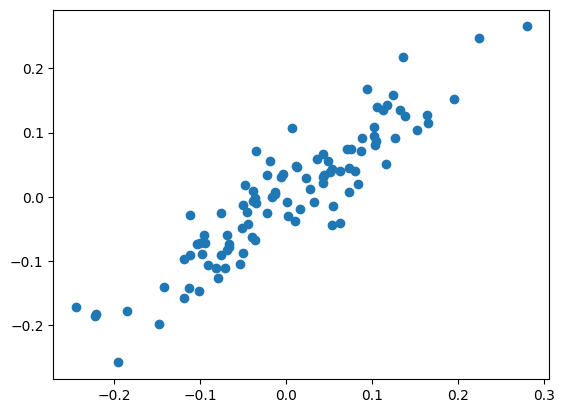

In [12]:
plt.scatter(word_data["embbeding_model_a"].values[0],word_data["embbeding_model_b"].values[0])

In [13]:
from scipy.stats import spearmanr
from scipy.stats import pearsonr

display(spearmanr(word_data["embbeding_model_a"].values[0],word_data["embbeding_model_b"].values[0]))
display(pearsonr(word_data["embbeding_model_a"].values[0],word_data["embbeding_model_b"].values[0]))

SignificanceResult(statistic=0.9093309330933094, pvalue=4.209882109466041e-39)

PearsonRResult(statistic=0.9157850532955004, pvalue=1.323292927356247e-40)

In [14]:
set_ = set()
for emotion in emotion_list:
    fst = set(poems_fst[emotion].wv.key_to_index.keys())
    w2v = set(poems_w2v[emotion].wv.key_to_index.keys())
    intersection = fst & w2v
    if not set_:
        set_ = set_.union(intersection)
    else:
        set_ = set_.intersection(intersection)

display(len(set_))
display(set_)

677

{'a',
 'about',
 'above',
 'across',
 'act',
 'after',
 'again',
 'against',
 'age',
 'ago',
 'ah',
 'air',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'always',
 'am',
 'among',
 'amp',
 'an',
 'ancient',
 'and',
 'angels',
 'another',
 'answer',
 'any',
 'are',
 'arms',
 'around',
 'as',
 'ask',
 'at',
 'away',
 'b',
 'back',
 'bare',
 'be',
 'bear',
 'beauty',
 'because',
 'become',
 'bed',
 'been',
 'before',
 'begin',
 'behind',
 'behold',
 'being',
 'beneath',
 'bent',
 'beside',
 'best',
 'better',
 'between',
 'beyond',
 'big',
 'bird',
 'birds',
 'bit',
 'black',
 'blind',
 'blood',
 'blow',
 'blue',
 'body',
 'book',
 'books',
 'born',
 'both',
 'bound',
 'bow',
 'brain',
 'branches',
 'bread',
 'break',
 'breast',
 'breath',
 'breathe',
 'breeze',
 'bright',
 'bring',
 'brought',
 'brown',
 'burn',
 'burst',
 'but',
 'by',
 'call',
 'called',
 'came',
 'can',
 'cant',
 'care',
 'cat',
 'chair',
 'cheek',
 'children',
 'city',
 'clay',
 'clear',
 'close',
 'c

In [15]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
set_ = set_ - stop_words
set_

{'across',
 'act',
 'age',
 'ago',
 'ah',
 'air',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'always',
 'among',
 'amp',
 'ancient',
 'angels',
 'another',
 'answer',
 'arms',
 'around',
 'ask',
 'away',
 'b',
 'back',
 'bare',
 'bear',
 'beauty',
 'become',
 'bed',
 'begin',
 'behind',
 'behold',
 'beneath',
 'bent',
 'beside',
 'best',
 'better',
 'beyond',
 'big',
 'bird',
 'birds',
 'bit',
 'black',
 'blind',
 'blood',
 'blow',
 'blue',
 'body',
 'book',
 'books',
 'born',
 'bound',
 'bow',
 'brain',
 'branches',
 'bread',
 'break',
 'breast',
 'breath',
 'breathe',
 'breeze',
 'bright',
 'bring',
 'brought',
 'brown',
 'burn',
 'burst',
 'call',
 'called',
 'came',
 'cant',
 'care',
 'cat',
 'chair',
 'cheek',
 'children',
 'city',
 'clay',
 'clear',
 'close',
 'clouds',
 'cold',
 'color',
 'come',
 'comes',
 'cool',
 'could',
 'country',
 'course',
 'cried',
 'cries',
 'cry',
 'cup',
 'cut',
 'dark',
 'day',
 'days',
 'dead',
 'dear',
 'death',
 'deep',
 'died',
 'dim',

In [16]:
from collections import Counter

def get_word_freq(dataframe:pd.DataFrame,col:str,emotion_list:list):
    """
    Calculates for Counter model of each emotion text corpus.

    Parameters
    ------------
    dataframe: pandas Dataframe with documents.
    col:str name of the column where the documents are.
    emotion_list: list with emotions

    Returns
    -----------
    dict:
        dictionary with keys(emotions_list) an each key with his self Counter model.
    """
    freq_dict = {}
    for emotion in emotion_list:
        tokens = dataframe[emotion][col].apply(lambda x: [token for token in word_tokenize(x)])
        l1 = tokens.values.tolist()
        l2 = [w for l in l1 for w in l ]
        freq_dict[emotion] = Counter(l2)
    return freq_dict

In [17]:
def text_clean(sent):
    import re
    from unidecode import unidecode
    import unicodedata as ud

    d = {ord('\N{combining acute accent}'):None}
    sent = ud.normalize('NFD',sent).translate(d)
    sent = re.sub(r"[^\w .,;?!\n]+", "", sent)
    sent = re.sub(r"[^\w .,;?!]", " ", sent)
    sent = re.sub(r"[^\w .,]", ".", sent)
    sent = re.sub(r"[^\w ]", "", sent)
    sent = re.sub(r"[0-9]", "", sent)
    sent = re.sub(r"[α-ωςϑϕϜϝϞϠϰϱ]", "", sent)
    sent = re.sub(r"[ΓΔΕΖΗΘΙΚΛΜΝΞΟΠΡΣΤΥΦΧΨΩ]", "", sent)
    sent = re.sub(r"[A-Z]{2}", "", sent)
    return sent

In [18]:
em_poem_c = dict()

for emotion in emotion_list:
    em_poem_c[emotion] = em_poems[emotion].copy()

for emotion in emotion_list:
    em_poem_c[emotion]["poems_clean"] = em_poem_c[emotion]["poem"].apply(text_clean)

freq_dict = get_word_freq(em_poem_c,"poems_clean",emotion_list)
freq_dict

{'anger': Counter({'the': 5646,
          'and': 3318,
          'of': 2235,
          'a': 1857,
          'to': 1720,
          'in': 1642,
          'i': 1193,
          'that': 872,
          'with': 815,
          'is': 719,
          'his': 688,
          'my': 668,
          'on': 597,
          'for': 596,
          'you': 590,
          'he': 563,
          'it': 557,
          'not': 549,
          'but': 513,
          'words': 481,
          'all': 476,
          'as': 443,
          'at': 410,
          'from': 397,
          'was': 394,
          'me': 383,
          'they': 381,
          'their': 356,
          'by': 349,
          'like': 342,
          'are': 338,
          'your': 336,
          'or': 330,
          'be': 323,
          'her': 323,
          'we': 310,
          'so': 304,
          'this': 290,
          'when': 286,
          'an': 283,
          'no': 268,
          'what': 257,
          'have': 249,
          'will': 232,
          'one': 227,
 

In [19]:
#Creamos el dataframe de las palabras con su correlacion pearson
from itertools import combinations

emotion_combinations = list(combinations(emotion_list,2))

words_embbed_info = {}
words_embbed_info["words"] = list(set_)

for emotion in emotion_list:
    words_embbed_info["f_"+emotion] = []

for comb in emotion_combinations:
    words_embbed_info["P_"+str(comb)] = []

for word in set_:
    #Añadimos la frecuencia por cada emoción
    for emotion in emotion_list:
        words_embbed_info["f_"+emotion].append(freq_dict[emotion][word])

    #Calculamos la correlacion pearson para cada par de emociones.    
    for comb in emotion_combinations:
        emotion_a = comb[0]
        emotion_b = comb[1]

        words_embbed_info["P_"+str(comb)].append(pearsonr(poems_w2v[emotion_a].wv.get_vector(word,norm=True),poems_w2v[emotion_b].wv.get_vector(word,norm=True)))
    
words_embbed_w2v_info = pd.DataFrame(words_embbed_info)
words_embbed_w2v_info

,words,f_anger,f_anticipation,f_disgust,f_fear,f_joy,f_sadness,f_surprise,f_trust,"P_('anger', 'anticipation')",...,"P_('fear', 'joy')","P_('fear', 'sadness')","P_('fear', 'surprise')","P_('fear', 'trust')","P_('joy', 'sadness')","P_('joy', 'surprise')","P_('joy', 'trust')","P_('sadness', 'surprise')","P_('sadness', 'trust')","P_('surprise', 'trust')"
0,shore,26,93,10,58,65,104,11,68,"(0.8964544747538589, 2.0523435421073133e-36)",...,"(0.8576704625044349, 4.584301036571661e-30)","(0.8708289988300942, 5.503890078957733e-32)","(0.8834269790339008, 4.938898301165854e-34)","(0.8762531572533665, 7.704393448581506e-33)","(0.8711239261414295, 4.957209827619224e-32)","(0.8856787020318934, 2.008651653293645e-34)","(0.8786366972926805, 3.152938774690757e-33)","(0.8974448954059783, 1.3133014910641124e-36)","(0.8955075929937776, 3.131745438224895e-36)","(0.8761444699462196, 8.021224155465546e-33)"
1,large,10,35,10,23,31,31,5,65,"(0.8930043786129279, 9.389291798942029e-36)",...,"(0.8495704220337206, 5.625516918048799e-29)","(0.8821259649015584, 8.236332103973501e-34)","(0.8756835591717425, 9.512175075872465e-33)","(0.8733705780991393, 2.2153262359521562e-32)","(0.8778553442373949, 4.234541902742882e-33)","(0.8829585395303867, 5.9416015521543925e-34)","(0.8701170326898975, 7.077621092051138e-32)","(0.8940549125924779, 5.942475350446646e-36)","(0.8947201217002582, 4.436984424262667e-36)","(0.8694304260447091, 9.00754044277856e-32)"
2,clay,8,16,5,13,17,45,6,45,"(0.9079587436283428, 8.496832096073857e-39)",...,"(0.848128873974867, 8.654547038770019e-29)","(0.8839423558047316, 4.026380414967872e-34)","(0.8635773516051326, 6.666695351841793e-31)","(0.8610945482270816, 1.5155334173336628e-30)","(0.8766773884873315, 6.580598794936848e-33)","(0.8518328611860767, 2.835096267999706e-29)","(0.8636155244864784, 6.582220606831136e-31)","(0.8904209267559975, 2.8347650618500663e-35)","(0.8922853273901702, 1.280628992674815e-35)","(0.85395739747975, 1.474250265547937e-29)"
3,cold,40,139,23,108,134,225,20,145,"(0.9028499214055868, 1.0572093926528329e-37)",...,"(0.8427120424343294, 4.2002893823347665e-28)","(0.8774982355288338, 4.84236149796145e-33)","(0.8842732617988355, 3.5296526663058953e-34)","(0.8673599537088226, 1.8485612147250384e-31)","(0.8785291795885294, 3.283928592258219e-33)","(0.8783458760901789, 3.5196062095771645e-33)","(0.8651072321739478, 3.986871008762558e-31)","(0.900938888651642, 2.619498351174574e-37)","(0.8960992132069988, 2.4061277699143114e-36)","(0.8717737842654173, 3.933084959806367e-32)"
4,keep,33,135,17,75,126,107,9,170,"(0.9140905660629975, 3.369325508473588e-40)",...,"(0.8768593611112434, 6.149173435432938e-33)","(0.8805342058144872, 1.5273518311381244e-33)","(0.8703924833763819, 6.422571929440865e-32)","(0.8713489783984358, 4.576079675531547e-32)","(0.8824084309719142, 7.3745497721899045e-34)","(0.8863064799822127, 1.5577862056663732e-34)","(0.8807835885466706, 1.3873056426207168e-33)","(0.8893751047322764, 4.39922223177955e-35)","(0.8767211536575844, 6.474215329862332e-33)","(0.872978147946324, 2.55279881537708e-32)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,dumb,7,24,8,27,15,17,5,28,"(0.9018791982857196, 1.6801061011240448e-37)",...,"(0.8582058631488337, 3.8631380812241345e-30)","(0.886258293964282, 1.5885631898478628e-34)","(0.8275250095276139, 2.608221586042919e-26)","(0.8637537140168232, 6.285063712205984e-31)","(0.8743234582537993, 1.5669604719197688e-32)","(0.8083774981024726, 2.769334817477716e-24)","(0.862855476980863, 8.478656473538896e-31)","(0.8617958503503819, 1.2037230077480287e-30)","(0.8941727342360222, 5.6435989870217204e-36)","(0.8365844022453925, 2.3376615883460283e-27)"
558,died,18,48,9,54,93,103,6,80,"(0.9123515183626514, 8.619472035917273e-40)",...,"(0.8733239243049719, 2.2530414471855747e-32)","(0.8693465306336303, 9.276005885628514e-32)","(0.8625928689759488, 9.250495304421222e-31)","(0.8798746799396228, 1.9676587754360226e-33)","(0.8693082868344654, 9.40

In [20]:
words_embbed_info = {}
words_embbed_info["words"] = list(set_)

for emotion in emotion_list:
    words_embbed_info["f_"+emotion] = []

for comb in emotion_combinations:
    words_embbed_info["P_"+str(comb)] = []

for word in set_:
    #Añadimos la frecuencia por cada emoción
    for emotion in emotion_list:
        words_embbed_info["f_"+emotion].append(freq_dict[emotion][word])

    #Calculamos la correlacion pearson para cada par de emociones.    
    for comb in emotion_combinations:
        emotion_a = comb[0]
        emotion_b = comb[1]

        words_embbed_info["P_"+str(comb)].append(pearsonr(poems_fst[emotion_a].wv.get_vector(word,norm=True),poems_fst[emotion_b].wv.get_vector(word,norm=True)))
    
words_embbed_fst_info = pd.DataFrame(words_embbed_info)
words_embbed_fst_info

,words,f_anger,f_anticipation,f_disgust,f_fear,f_joy,f_sadness,f_surprise,f_trust,"P_('anger', 'anticipation')",...,"P_('fear', 'joy')","P_('fear', 'sadness')","P_('fear', 'surprise')","P_('fear', 'trust')","P_('joy', 'sadness')","P_('joy', 'surprise')","P_('joy', 'trust')","P_('sadness', 'surprise')","P_('sadness', 'trust')","P_('surprise', 'trust')"
0,shore,26,93,10,58,65,104,11,68,"(0.8893781600318634, 4.393606078256132e-35)",...,"(0.892799552466814, 1.025950373655879e-35)","(0.9016597020491024, 1.8643819219251174e-37)","(0.8745531871714783, 1.4408543725186893e-32)","(0.8810863512526164, 1.2340689390019859e-33)","(0.8349411170761492, 3.660047683015374e-27)","(0.8130189408353581, 9.391095965256646e-25)","(0.8761113999733638, 8.12012530088171e-33)","(0.886484731923623, 1.448916394589989e-34)","(0.8837834251866835, 4.288617738088078e-34)","(0.8623041645001599, 1.01782454490782e-30)"
1,large,10,35,10,23,31,31,5,65,"(0.8823029127501024, 7.685642703994852e-34)",...,"(0.8890096817417346, 5.124041894973353e-35)","(0.8527079330921447, 2.1683688106222388e-29)","(0.876127586416401, 8.071569202845226e-33)","(0.8842531733408543, 3.558019815986629e-34)","(0.8477658781504671, 9.639353453345994e-29)","(0.8368170676496515, 2.1930071554364543e-27)","(0.8755631597288134, 9.944247737656172e-33)","(0.8381571032597191, 1.5149924428737482e-27)","(0.8970991394976421, 1.5355857579688185e-36)","(0.8734131497376828, 2.1814495165060759e-32)"
2,clay,8,16,5,13,17,45,6,45,"(0.8831413429781162, 5.528642831585227e-34)",...,"(0.8856003687940311, 2.0731677814047867e-34)","(0.8658778686862092, 3.0698972523798138e-31)","(0.8737582169456823, 1.9249043087290984e-32)","(0.8874852882590071, 9.626004773657143e-35)","(0.856477223367573, 6.696560691128933e-30)","(0.8391207810964483, 1.1587451770194046e-27)","(0.8696141190338661, 8.445943293857556e-32)","(0.8614040306227161, 1.3692608157199054e-30)","(0.9013331627512051, 2.175597801522029e-37)","(0.8817744239824401, 9.447101409437783e-34)"
3,cold,40,139,23,108,134,225,20,145,"(0.8797220200865571, 2.0860361914454818e-33)",...,"(0.8776924268613963, 4.50198184009997e-33)","(0.8378719662000351, 1.6395021080835788e-27)","(0.8755682678366572, 9.925533249739198e-33)","(0.8668176209705958, 2.227153332034267e-31)","(0.8453424188880971, 1.9653022700771815e-28)","(0.8329719415557723, 6.223144985521105e-27)","(0.8599329582917714, 2.2134340489583292e-30)","(0.8303582675810126, 1.2456335777513606e-26)","(0.8885625463292826, 6.170864732409504e-35)","(0.8610252106489852, 1.550338881990661e-30)"
4,keep,33,135,17,75,126,107,9,170,"(0.8894838241393083, 4.203629897378663e-35)",...,"(0.8873695375760648, 1.0094328649888933e-34)","(0.9038913869210455, 6.396685469748336e-38)","(0.8744313707143554, 1.5064358724547155e-32)","(0.8607648492210974, 1.688136258023859e-30)","(0.85150968496571, 3.128812218645985e-29)","(0.8257994465113568, 4.0641439802162244e-26)","(0.8307141114344223, 1.1341255958843006e-26)","(0.8909321396951548, 2.283059767522519e-35)","(0.8869104652774449, 1.2180938265823207e-34)","(0.8572406771671226, 5.256826682582344e-30)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,dumb,7,24,8,27,15,17,5,28,"(0.8908701739324362, 2.34388438660363e-35)",...,"(0.894213592038852, 5.543426271075399e-36)","(0.8782604089153396, 3.635064328529201e-33)","(0.8773643361222788, 5.0915700759219085e-33)","(0.8799443262596652, 1.9158571391485214e-33)","(0.8246902910068543, 5.391007308363717e-26)","(0.834494461552558, 4.1308537679460744e-27)","(0.8456846706705009, 1.778524405972077e-28)","(0.8680019549671256, 1.4811013310668674e-31)","(0.9100773077944032, 2.859807456244327e-39)","(0.8744410795795801, 1.5011038071492278e-32)"
558,died,18,48,9,54,93,103,6,80,"(0.8859963579554287, 1.7665450858751634e-34)",...,"(0.8961153034628082, 2.388888525585352e-36)","(0.9024392455260734, 1.2868509276397622e-37)","(0.8761498334556463, 8.005294976253291e-33)","(0.8626567835835615, 9.056555160452356e-31)","(0.8612724469449792, 

# Modulación de las palabras

In [21]:
#Muestra de la modulación

# Samples per second
sps = 44100

# Duration
duration_s = 5.0

In [22]:
# carrier_hz: Frequency of the carrier
# fm_hz: Frequency of the frequency modulator
# k_p: deviation constant
carrier_amplitude = 1.0
carrier_hz = 440.0
fm_hz = 220.0
k = 25.0

In [23]:
# First, define our range of sample numbers
each_sample_number = np.arange(duration_s * sps)

# Create the term that create the carrier
carrier = 2 * np.pi * each_sample_number * carrier_hz / sps

# Now create the term that is the frequency modulator
modulator = k * np.sin(2 * np.pi * each_sample_number * fm_hz / sps)

# Now create the modulated waveform, and attenuate it
waveform = np.cos(carrier + modulator)
waveform_quiet = waveform * 0.3

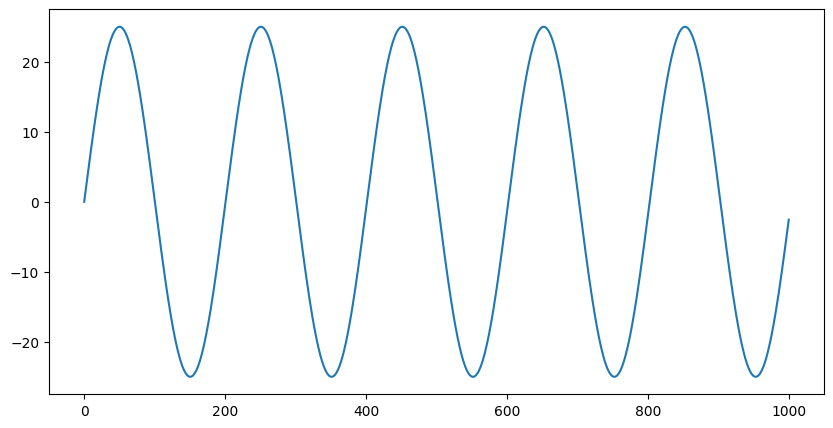

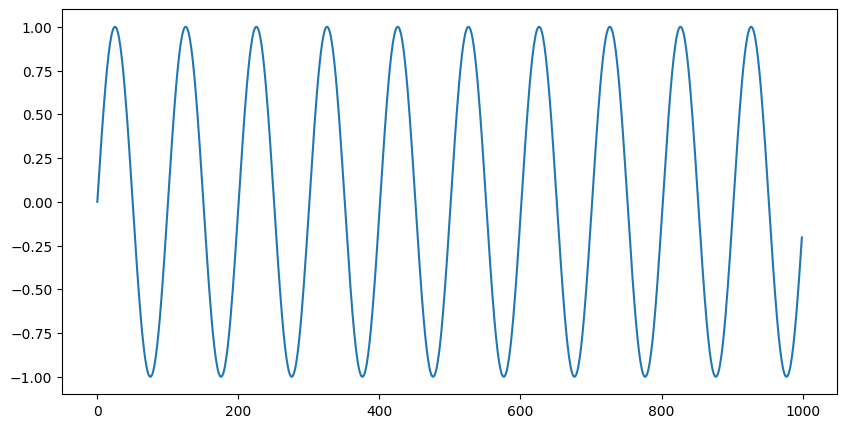

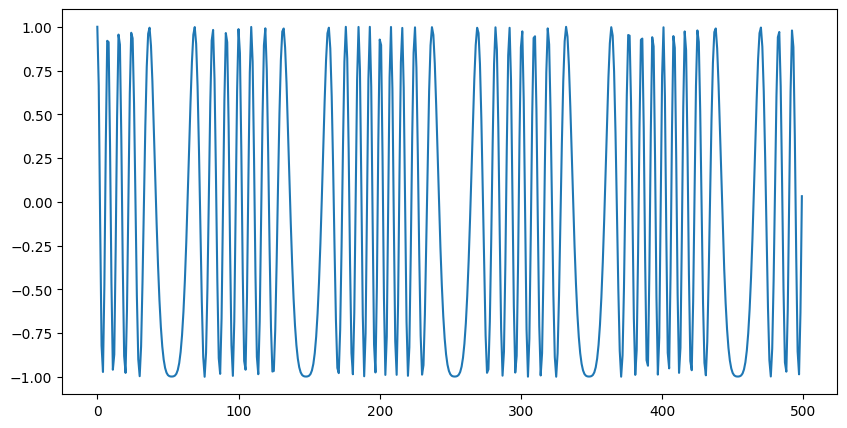

In [24]:
#Graphs
plt.figure(figsize=(10,5))
plt.plot(modulator[:1000])

plt.figure(figsize=(10,5))
plt.plot(np.sin(carrier[:1000]))

plt.figure(figsize=(10,5))
plt.plot(waveform[:500])

Muestra de embbeding modulado.

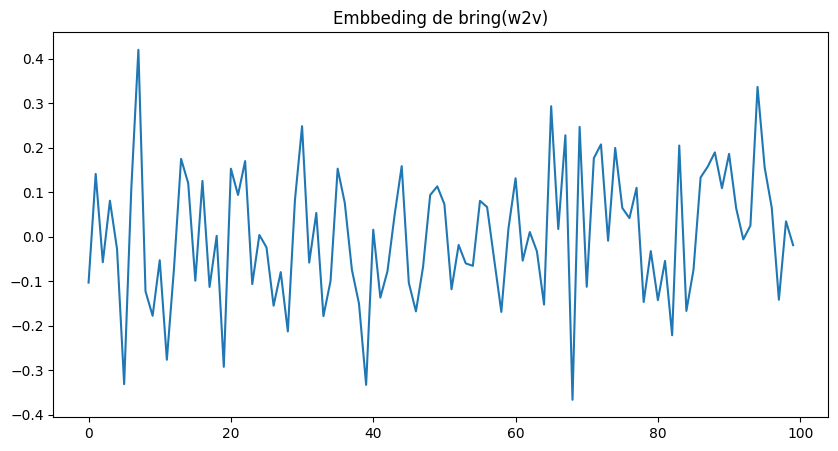

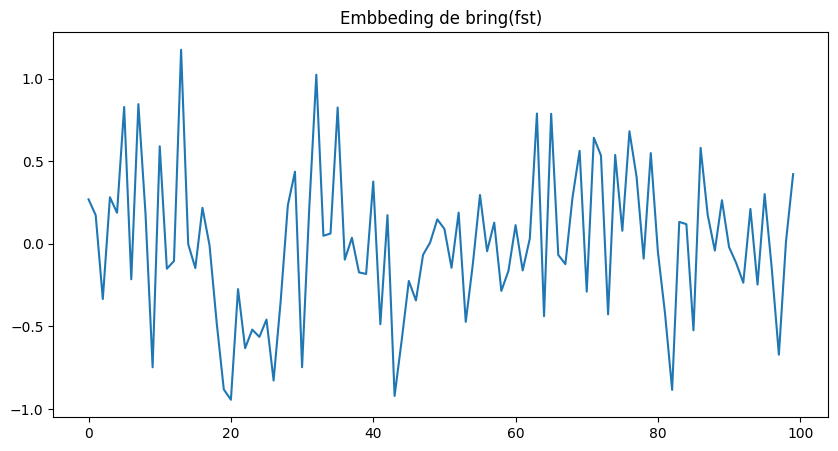

In [25]:
word = "bring"
emotion = "anger"
embbed_w2v = poems_w2v[emotion].wv.get_vector(word)
embbed_fst = poems_fst[emotion].wv.get_vector(word)

plt.figure(figsize=(10,5))
plt.title("Embbeding de "+word+"(w2v)")
plt.plot(embbed_w2v)

plt.figure(figsize=(10,5))
plt.title("Embbeding de "+word+"(fst)")
plt.plot(embbed_fst)

In [26]:
# Samples per second
sps = 100

# Duration
duration_s = 1.0

# ac: amplitude of the carrier. Should be kept at 1.0 in this script
# you would modify it if you were micing it with, or modulating other,
# waveforms.

# carrier_hz: Frequency of the carrier
# fm_hz: Frequency of the frequency modulator
# k_p: deviation constant
carrier_amplitude = 1.0
carrier_hz = 3.0
fm_hz = 50.0
k = 50


each_sample_number = np.arange(duration_s * sps)

carrier = 2 * np.pi * each_sample_number * carrier_hz / sps

#modulator = k * np.sin(2 * np.pi * each_sample_number * fm_hz / sps)
modulator = embbed_w2v
# Now create the modulated waveform, and attenuate it
waveform = np.cos(carrier + k*modulator)

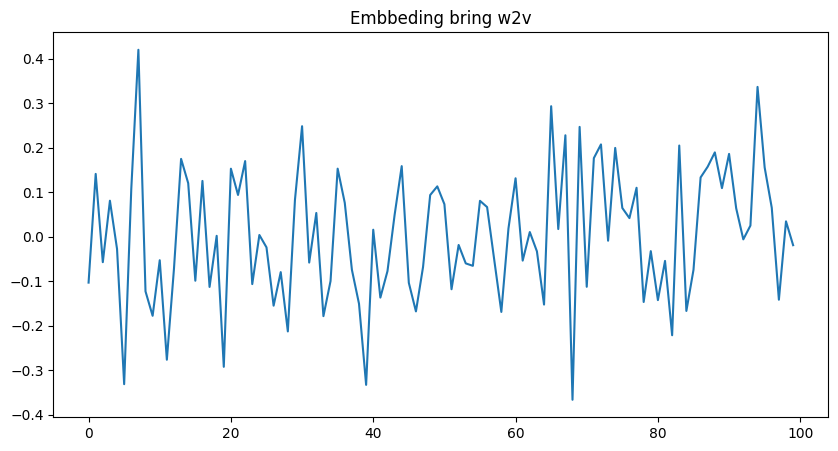

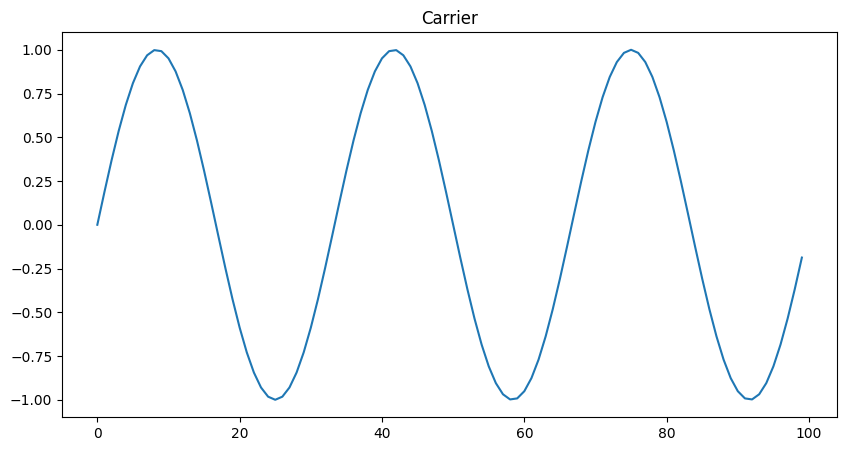

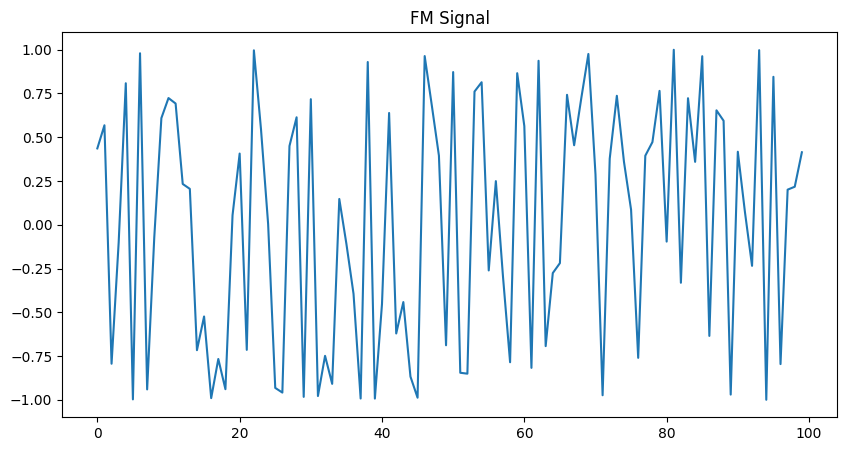

In [27]:
plt.figure(figsize=(10,5))
plt.title("Embbeding "+ word + " w2v")
plt.plot(embbed_w2v)

plt.figure(figsize=(10,5))
plt.title("Carrier")
plt.plot(np.sin(carrier))

plt.figure(figsize=(10,5))
plt.title("FM Signal")
plt.plot(waveform)

# Prueba de separación e impacto en la semántica.

In [28]:
# Samples per second
sps = 100

# Duration
duration_s = 1.0

# ac: amplitude of the carrier. Should be kept at 1.0 in this script
# you would modify it if you were micing it with, or modulating other,
# waveforms.

# carrier_hz: Frequency of the carrier
# fm_hz: Frequency of the frequency modulator
# k_p: deviation constant

# Samples per second
sps = 100

# Duration
duration_s = 1.0

carrier_hz_a = 2
carrier_hz_b = 5
k = 50

words_embbed_info = {}
words_embbed_info["words"] = list(set_)

for emotion in emotion_list:
    words_embbed_info["f_"+emotion] = []

for comb in emotion_combinations:
    words_embbed_info["P_"+str(comb)] = []

for word in set_:
    #Añadimos la frecuencia por cada emoción
    for emotion in emotion_list:
        words_embbed_info["f_"+emotion].append(freq_dict[emotion][word])

    #Calculamos la correlacion pearson para cada par de emociones.    
    for comb in emotion_combinations:
        emotion_a = comb[0]
        emotion_b = comb[1]
        

        embbeding_a = poems_fst[emotion_a].wv.get_vector(word,norm=True)
        embbeding_b = poems_fst[emotion_b].wv.get_vector(word,norm=True)

        carrier_a = 2 * np.pi * each_sample_number * carrier_hz_a / sps
        carrier_b = 2 * np.pi * each_sample_number * carrier_hz_b / sps

        fm_embbed_a = np.cos(carrier_a + k*embbeding_a)
        fm_embbed_b = np.cos(carrier_b + k*embbeding_b)

        words_embbed_info["P_"+str(comb)].append(pearsonr(fm_embbed_a,fm_embbed_b))

words_embbed_fst_mod = pd.DataFrame(words_embbed_info)
words_embbed_fst_mod

,words,f_anger,f_anticipation,f_disgust,f_fear,f_joy,f_sadness,f_surprise,f_trust,"P_('anger', 'anticipation')",...,"P_('fear', 'joy')","P_('fear', 'sadness')","P_('fear', 'surprise')","P_('fear', 'trust')","P_('joy', 'sadness')","P_('joy', 'surprise')","P_('joy', 'trust')","P_('sadness', 'surprise')","P_('sadness', 'trust')","P_('surprise', 'trust')"
0,shore,26,93,10,58,65,104,11,68,"(-0.002263441354720098, 0.9821688697381399)",...,"(-0.09714682839082088, 0.3362851402277223)","(0.001879550820702543, 0.9851927383640052)","(-0.10131363746828227, 0.31586939659941565)","(-0.039793370952148514, 0.6942556262114218)","(0.04410438865381663, 0.6630464278843806)","(-0.05178205596631277, 0.6088933657734724)","(-0.019469651231189333, 0.8475331414439198)","(0.043933710769448686, 0.6642715804613771)","(-0.0489114549895035, 0.6289149920528244)","(0.046195092474864606, 0.6481118349157804)"
1,large,10,35,10,23,31,31,5,65,"(-0.07809799773591994, 0.4399120120375761)",...,"(0.06258730606028906, 0.5361725176601165)","(-0.014169202895741142, 0.8887250816775574)","(-0.09239675577003435, 0.3605546013142464)","(-0.0009417221311950634, 0.9925807186769658)","(-0.010125585925085456, 0.920355938440888)","(-0.027486782602803947, 0.7860346879244381)","(-0.03290950287265142, 0.7451465962653252)","(0.034445014879891274, 0.733690449865841)","(-0.07111306944825518, 0.4820053519658399)","(-0.002674523126455398, 0.9789310991402748)"
2,clay,8,16,5,13,17,45,6,45,"(-0.06992065356314761, 0.48940060438121274)",...,"(0.07766944818408575, 0.44243323366836157)","(-0.045203840551450936, 0.6551757657900193)","(-0.11820406654894763, 0.2414818288376607)","(0.027721798262477112, 0.7842496346080526)","(-0.021751222128256392, 0.8299209501281121)","(-0.03619154852885766, 0.7207306530049827)","(0.002165079264310737, 0.9829436360877398)","(0.020507966092004636, 0.8395082031454416)","(-0.06246999507171913, 0.5369383245387858)","(0.012168618676550138, 0.9043558299134754)"
3,cold,40,139,23,108,134,225,20,145,"(-0.0984626457863113, 0.3297497514548412)",...,"(0.08304119643879286, 0.41142323359365623)","(-0.02055439263362371, 0.8391497582131789)","(-0.0909088164165632, 0.3683740769505823)","(0.05988854757473598, 0.5539258277784852)","(-0.043881584080535836, 0.6646459303361129)","(-0.08907106742653616, 0.3781740937736303)","(0.011902237609456762, 0.906439978335511)","(0.03739261535398292, 0.7118637375606068)","(-0.011266959696381017, 0.9114128870642715)","(0.04595846306600874, 0.6497953190385527)"
4,keep,33,135,17,75,126,107,9,170,"(-0.025622531155138333, 0.8002330824415128)",...,"(-0.06414988938583814, 0.5260238755555043)","(0.06597694361084552, 0.5142814183133831)","(-0.10297339317335938, 0.3079652884530798)","(0.10915961247856855, 0.27964974732586784)","(-0.010389127136549901, 0.9182900815381512)","(0.048848279650458806, 0.6293587301901094)","(-0.12336123545623615, 0.22141299755577262)","(0.09737135847147256, 0.3351641787670248)","(-0.07350492057410549, 0.46735350208076687)","(-0.051701717439818884, 0.6094498905293062)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,dumb,7,24,8,27,15,17,5,28,"(0.031099948960710774, 0.7587187232515591)",...,"(-0.005828172450768925, 0.9541075085103925)","(-0.00715891607203675, 0.9436444769762934)","(-0.10463773092770574, 0.30016989070914546)","(-0.037781322273478135, 0.7090022264448143)","(-0.05084719980655065, 0.6153830657620983)","(0.030583630188604972, 0.7626049139127734)","(0.11989444128189085, 0.23476955272810288)","(0.008064017922613282, 0.9365334304862816)","(-0.10367374761052994, 0.30466905227099045)","(-0.031971786780093825, 0.7521702854776092)"
558,died,18,48,9,54,93,103,6,80,"(-0.019538876502837737, 0.8469976183963375)",...,"(-0.2474593554044848, 0.01305678641235915)","(0.13636759313203653, 0.17610026741359436)","(-0.10357668102730425, 0.3051245170173633)","(-0.007823498204648182, 0.9384226408059753)","(-0.08451728900369279, 0.40313000948695266)","(0.03961067646080586, 0.6955900260130538)","(0.092

In [29]:
words_embbed_info = {}
words_embbed_info["words"] = list(set_)

for emotion in emotion_list:
    words_embbed_info["f_"+emotion] = []

for comb in emotion_combinations:
    words_embbed_info["P_"+str(comb)] = []

for word in set_:
    #Añadimos la frecuencia por cada emoción
    for emotion in emotion_list:
        words_embbed_info["f_"+emotion].append(freq_dict[emotion][word])

    #Calculamos la correlacion pearson para cada par de emociones.    
    for comb in emotion_combinations:
        emotion_a = comb[0]
        emotion_b = comb[1]
        

        embbeding_a = poems_w2v[emotion_a].wv.get_vector(word,norm=True)
        embbeding_b = poems_w2v[emotion_b].wv.get_vector(word,norm=True)

        carrier_a = 2 * np.pi * each_sample_number * carrier_hz_a / sps
        carrier_b = 2 * np.pi * each_sample_number * carrier_hz_b / sps

        fm_embbed_a = np.cos(carrier_a + k*embbeding_a)
        fm_embbed_b = np.cos(carrier_b + k*embbeding_b)

        words_embbed_info["P_"+str(comb)].append(pearsonr(fm_embbed_a,fm_embbed_b))

words_embbed_w2v_mod = pd.DataFrame(words_embbed_info)
words_embbed_w2v_mod

,words,f_anger,f_anticipation,f_disgust,f_fear,f_joy,f_sadness,f_surprise,f_trust,"P_('anger', 'anticipation')",...,"P_('fear', 'joy')","P_('fear', 'sadness')","P_('fear', 'surprise')","P_('fear', 'trust')","P_('joy', 'sadness')","P_('joy', 'surprise')","P_('joy', 'trust')","P_('sadness', 'surprise')","P_('sadness', 'trust')","P_('surprise', 'trust')"
0,shore,26,93,10,58,65,104,11,68,"(0.03443693191603061, 0.7337506051665627)",...,"(0.002666458017326583, 0.9789946186017434)","(0.06162909168232426, 0.5424435483123295)","(-0.03859917328595319, 0.7029947477644114)","(0.0013208667268046212, 0.989593801604677)","(0.13095177048659842, 0.1940627104746055)","(0.043616955835712, 0.6665476373767947)","(-0.1450198038524149, 0.14998410939656734)","(-0.0933440043971479, 0.3556304307677925)","(-0.11678425795520295, 0.24722157842786366)","(0.03136438260370087, 0.7567307177880128)"
1,large,10,35,10,23,31,31,5,65,"(-0.03126523264411857, 0.7574759397458056)",...,"(0.011261863833271026, 0.911452791181408)","(0.06569254909062841, 0.5161003583772874)","(0.0515615067205837, 0.6104216976953112)","(-0.012163447434111234, 0.9043962832557736)","(0.1321750956205084, 0.18989396703806305)","(0.024397912097883688, 0.8095957631688833)","(-0.09611080238924326, 0.34148819303819666)","(-0.22311194365388187, 0.025662963143574385)","(-0.09551644407184076, 0.3444959096230036)","(-0.2718550052543065, 0.0062171591158953895)"
2,clay,8,16,5,13,17,45,6,45,"(-0.041729799546921034, 0.6801699920104187)",...,"(0.039890487442516706, 0.6935466671228178)","(0.06353029928490424, 0.5300363848996243)","(-0.061308364767593784, 0.544550556409566)","(0.01665016923582744, 0.8694007286838854)","(0.17170437670154218, 0.08760534502462992)","(0.03026472411297241, 0.7650081868764159)","(-0.010620087838314769, 0.9164800639606074)","(0.0003141423545804864, 0.9975250237641242)","(0.014574364116703419, 0.8855645027487488)","(-0.030639671273505274, 0.762182820823529)"
3,cold,40,139,23,108,134,225,20,145,"(-0.049220602440468386, 0.6267454718216883)",...,"(0.05128879542548584, 0.6123138089220461)","(0.04901128015121231, 0.6282140976992058)","(-0.14681187044252667, 0.1449587390888241)","(-0.021121514660826797, 0.8347738578684407)","(0.19842196747930219, 0.04781633572047739)","(0.03134182078866556, 0.7569002753153425)","(-0.09981030828463518, 0.32314074663860115)","(-0.10108232925591781, 0.31698125545974115)","(-0.08627344126192843, 0.39339287810697515)","(-0.1097914028452171, 0.2768593211378411)"
4,keep,33,135,17,75,126,107,9,170,"(-0.011921296466604508, 0.906290841814891)",...,"(0.014516023576747117, 0.8860194959764616)","(0.04434174032570663, 0.6613441550639574)","(0.031563018992048594, 0.7552384154558838)","(-0.00905019062470849, 0.9287911298819298)","(-0.1279780535694373, 0.204471193123255)","(-0.1410529955396769, 0.16157162297891603)","(-0.05151323354117943, 0.6107564380182647)","(-0.023445936757808938, 0.8168926336999672)","(0.056447422392267084, 0.5769656353808988)","(0.013171543458433991, 0.896514943774677)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,dumb,7,24,8,27,15,17,5,28,"(-0.07585348476293677, 0.45320667129489733)",...,"(0.03294184112773588, 0.7449047439474605)","(0.13679329221716754, 0.1747419317771811)","(0.013035316646068622, 0.8975794009676649)","(-0.011432354303185946, 0.9101178533953441)","(-0.08649128392579655, 0.39219488907948025)","(-0.11474864951456637, 0.25561376772921696)","(-0.05712223188211618, 0.572412626079435)","(0.09937549945025409, 0.3252637161920106)","(-0.006050116827199673, 0.9523618714369465)","(-0.16637169488736986, 0.09805616570303852)"
558,died,18,48,9,54,93,103,6,80,"(0.027575723164198093, 0.7853590121560986)",...,"(-0.12443263811470509, 0.21739583106713115)","(0.0952250792814756, 0.34597640473052804)","(-0.04493489733242845, 0.6570976135733475)","(0.054075712170165935, 0.5930996218705956)","(-0.02036717326290441, 0.8405954210535406)","(-0.07538543834642664, 0.45600686018476966)","(-0.16513284724758592, 0.

In [30]:
#Información de correlacion datos modulados.
pearsonr_mod_data_w2v = {}
for comb in emotion_combinations:
    pearsonr_mod_data_w2v[comb] = [data[0] for data in words_embbed_w2v_mod["P_"+str(comb)]]

pearsonr_mod_data_fst = {}

for comb in emotion_combinations:
    pearsonr_mod_data_fst[comb] = [data[0] for data in words_embbed_fst_mod["P_"+str(comb)]]

#Información de correlacion datos no modulados.
pearsonr_data_w2v = {}
for comb in emotion_combinations:
    pearsonr_data_w2v[comb] = [data[0] for data in words_embbed_w2v_info["P_"+str(comb)]]

pearsonr_data_fst = {}
for comb in emotion_combinations:
    pearsonr_data_fst[comb] = [data[0] for data in words_embbed_fst_info["P_"+str(comb)]]


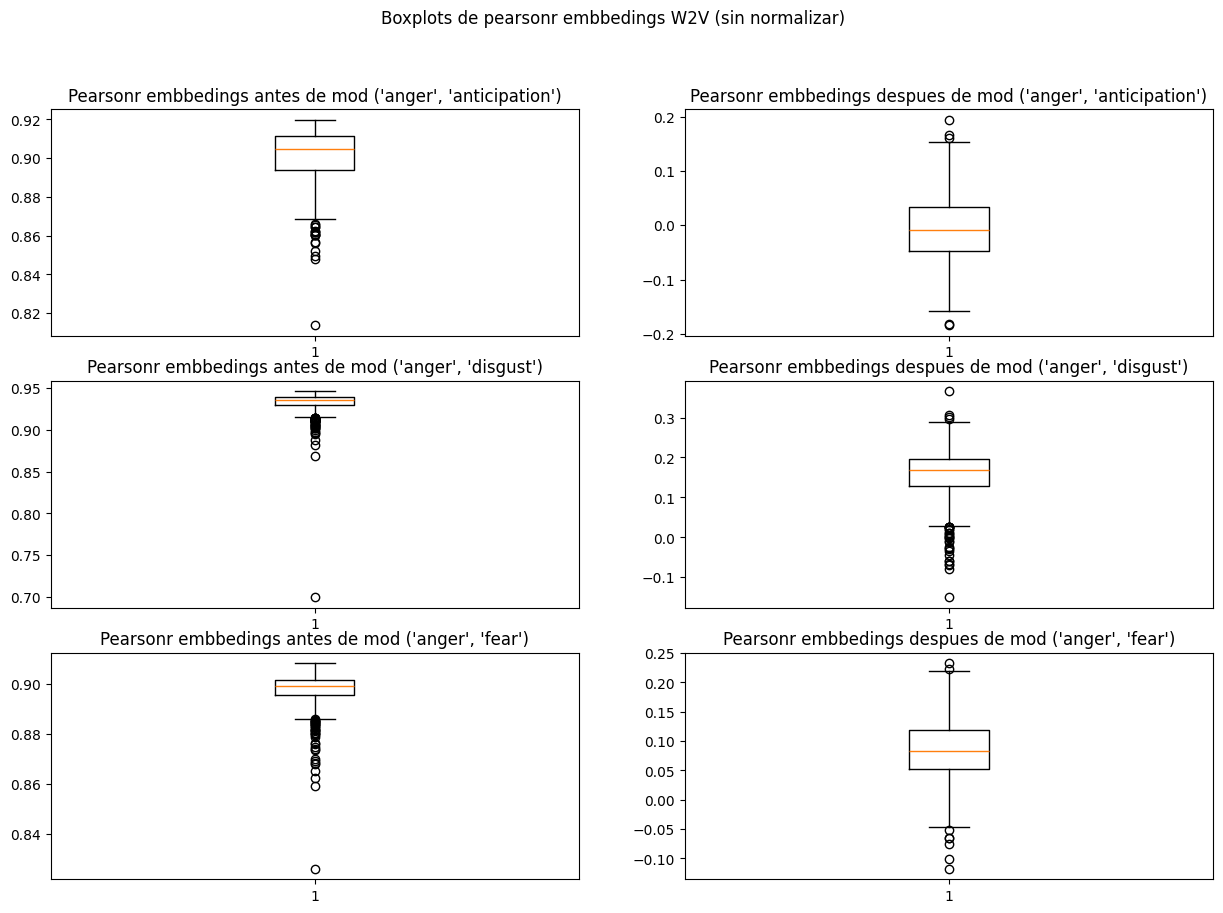

In [31]:
fig,ax = plt.subplots(3,2,figsize=(15,10))

fig.suptitle("Boxplots de pearsonr embbedings W2V (sin normalizar)")
for i in range(3):
    comb = emotion_combinations[i]
    ax[i,0].set_title("Pearsonr embbedings antes de mod "+str(comb))
    ax[i,0].boxplot(pearsonr_data_w2v[comb])

    ax[i,1].set_title("Pearsonr embbedings despues de mod "+str(comb))
    ax[i,1].boxplot(pearsonr_mod_data_w2v[comb])
plt.show()

In [32]:
words_embbed_info = {}
words_embbed_info["words"] = list(set_)

for emotion in emotion_list:
    words_embbed_info["f_"+emotion] = []

for comb in emotion_combinations:
    words_embbed_info["P_"+str(comb)] = []

for word in set_:
    #Añadimos la frecuencia por cada emoción
    for emotion in emotion_list:
        words_embbed_info["f_"+emotion].append(freq_dict[emotion][word])

    #Calculamos la correlacion pearson para cada par de emociones.    
    for comb in emotion_combinations:
        emotion_a = comb[0]
        emotion_b = comb[1]
        

        embbeding_a = poems_fst[emotion_a].wv.get_vector(word,norm=True)
        embbeding_b = poems_fst[emotion_b].wv.get_vector(word,norm=True)

        carrier_a = 2 * np.pi * each_sample_number * carrier_hz_a / sps
        carrier_b = 2 * np.pi * each_sample_number * carrier_hz_b / sps

        fm_embbed_a = np.cos(carrier_a + k*embbeding_a)
        fm_embbed_b = np.cos(carrier_b + k*embbeding_b)

        fm_embbed_a_normalized = fm_embbed_a / np.sqrt(np.sum(fm_embbed_a**2))
        fm_embbed_b_normalized = fm_embbed_b / np.sqrt(np.sum(fm_embbed_b**2))

        words_embbed_info["P_"+str(comb)].append(pearsonr(fm_embbed_a_normalized,fm_embbed_b_normalized))

words_embbed_fst_mod_norm = pd.DataFrame(words_embbed_info)
words_embbed_fst_mod_norm

,words,f_anger,f_anticipation,f_disgust,f_fear,f_joy,f_sadness,f_surprise,f_trust,"P_('anger', 'anticipation')",...,"P_('fear', 'joy')","P_('fear', 'sadness')","P_('fear', 'surprise')","P_('fear', 'trust')","P_('joy', 'sadness')","P_('joy', 'surprise')","P_('joy', 'trust')","P_('sadness', 'surprise')","P_('sadness', 'trust')","P_('surprise', 'trust')"
0,shore,26,93,10,58,65,104,11,68,"(-0.002263441354720112, 0.9821688697381399)",...,"(-0.09714682839082087, 0.3362851402277223)","(0.0018795508207025162, 0.9851927383640052)","(-0.10131363746828224, 0.31586939659941665)","(-0.039793370952148514, 0.6942556262114218)","(0.044104388653816634, 0.6630464278843806)","(-0.0517820559663128, 0.6088933657734724)","(-0.01946965123118931, 0.8475331414439198)","(0.043933710769448665, 0.6642715804613771)","(-0.04891145498950354, 0.6289149920528244)","(0.04619509247486464, 0.6481118349157804)"
1,large,10,35,10,23,31,31,5,65,"(-0.07809799773591992, 0.4399120120375761)",...,"(0.06258730606028905, 0.5361725176601165)","(-0.01416920289574111, 0.8887250816775574)","(-0.09239675577003435, 0.3605546013142464)","(-0.0009417221311950625, 0.9925807186769658)","(-0.010125585925085483, 0.920355938440888)","(-0.027486782602803954, 0.7860346879244381)","(-0.03290950287265139, 0.7451465962653252)","(0.0344450148798913, 0.733690449865841)","(-0.07111306944825517, 0.4820053519658399)","(-0.0026745231264554293, 0.9789310991402748)"
2,clay,8,16,5,13,17,45,6,45,"(-0.06992065356314764, 0.48940060438121274)",...,"(0.07766944818408575, 0.44243323366836157)","(-0.04520384055145093, 0.6551757657900193)","(-0.11820406654894766, 0.2414818288376607)","(0.027721798262477067, 0.7842496346080526)","(-0.021751222128256406, 0.8299209501281121)","(-0.036191548528857656, 0.7207306530049827)","(0.002165079264310716, 0.9829436360877398)","(0.020507966092004642, 0.8395082031454416)","(-0.062469995071719145, 0.5369383245387858)","(0.01216861867655013, 0.9043558299134754)"
3,cold,40,139,23,108,134,225,20,145,"(-0.09846264578631132, 0.3297497514548412)",...,"(0.08304119643879286, 0.41142323359365623)","(-0.020554392633623696, 0.8391497582131789)","(-0.0909088164165632, 0.3683740769505823)","(0.05988854757473598, 0.5539258277784852)","(-0.043881584080535836, 0.6646459303361129)","(-0.08907106742653617, 0.3781740937736303)","(0.011902237609456738, 0.9064399783355126)","(0.03739261535398298, 0.7118637375606068)","(-0.01126695969638099, 0.9114128870642715)","(0.04595846306600873, 0.6497953190385527)"
4,keep,33,135,17,75,126,107,9,170,"(-0.02562253115513834, 0.8002330824415128)",...,"(-0.06414988938583814, 0.5260238755555043)","(0.0659769436108455, 0.5142814183133831)","(-0.10297339317335942, 0.3079652884530798)","(0.10915961247856855, 0.27964974732586784)","(-0.010389127136549915, 0.9182900815381512)","(0.04884827965045882, 0.6293587301901094)","(-0.12336123545623615, 0.22141299755577262)","(0.09737135847147255, 0.3351641787670248)","(-0.07350492057410547, 0.46735350208076687)","(-0.05170171743981888, 0.6094498905293062)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,dumb,7,24,8,27,15,17,5,28,"(0.031099948960710805, 0.7587187232515582)",...,"(-0.005828172450768925, 0.9541075085103925)","(-0.007158916072036758, 0.9436444769762934)","(-0.10463773092770577, 0.30016989070914546)","(-0.03778132227347813, 0.7090022264448143)","(-0.05084719980655061, 0.6153830657620999)","(0.03058363018860496, 0.7626049139127734)","(0.11989444128189085, 0.23476955272810288)","(0.008064017922613286, 0.9365334304862816)","(-0.10367374761052993, 0.30466905227099145)","(-0.03197178678009381, 0.7521702854776107)"
558,died,18,48,9,54,93,103,6,80,"(-0.01953887650283774, 0.8469976183963375)",...,"(-0.2474593554044848, 0.01305678641235915)","(0.1363675931320365, 0.17610026741359436)","(-0.10357668102730425, 0.3051245170173633)","(-0.007823498204648203, 0.9384226408059753)","(-0.0845172890036928, 0.40313000948695266)","(0.03961067646080586, 0.6955900260130538)","(0.092722738228

In [33]:
words_embbed_info = {}
words_embbed_info["words"] = list(set_)

for emotion in emotion_list:
    words_embbed_info["f_"+emotion] = []

for comb in emotion_combinations:
    words_embbed_info["P_"+str(comb)] = []

for word in set_:
    #Añadimos la frecuencia por cada emoción
    for emotion in emotion_list:
        words_embbed_info["f_"+emotion].append(freq_dict[emotion][word])

    #Calculamos la correlacion pearson para cada par de emociones.    
    for comb in emotion_combinations:
        emotion_a = comb[0]
        emotion_b = comb[1]
        

        embbeding_a = poems_w2v[emotion_a].wv.get_vector(word,norm=True)
        embbeding_b = poems_w2v[emotion_b].wv.get_vector(word,norm=True)

        carrier_a = 2 * np.pi * each_sample_number * carrier_hz_a / sps
        carrier_b = 2 * np.pi * each_sample_number * carrier_hz_b / sps

        fm_embbed_a = np.cos(carrier_a + k*embbeding_a)
        fm_embbed_b = np.cos(carrier_b + k*embbeding_b)

        fm_embbed_a_normalized = fm_embbed_a / np.sqrt(np.sum(fm_embbed_a**2))
        fm_embbed_b_normalized = fm_embbed_b / np.sqrt(np.sum(fm_embbed_b**2))

        words_embbed_info["P_"+str(comb)].append(pearsonr(fm_embbed_a_normalized,fm_embbed_b_normalized))

words_embbed_w2v_mod_norm = pd.DataFrame(words_embbed_info)
words_embbed_w2v_mod_norm

,words,f_anger,f_anticipation,f_disgust,f_fear,f_joy,f_sadness,f_surprise,f_trust,"P_('anger', 'anticipation')",...,"P_('fear', 'joy')","P_('fear', 'sadness')","P_('fear', 'surprise')","P_('fear', 'trust')","P_('joy', 'sadness')","P_('joy', 'surprise')","P_('joy', 'trust')","P_('sadness', 'surprise')","P_('sadness', 'trust')","P_('surprise', 'trust')"
0,shore,26,93,10,58,65,104,11,68,"(0.034436931916030616, 0.7337506051665627)",...,"(0.002666458017326536, 0.9789946186017434)","(0.06162909168232424, 0.5424435483123295)","(-0.038599173285953206, 0.7029947477644114)","(0.0013208667268046152, 0.989593801604677)","(0.13095177048659845, 0.19406271047460452)","(0.04361695583571197, 0.6665476373767947)","(-0.1450198038524149, 0.14998410939656734)","(-0.0933440043971479, 0.3556304307677925)","(-0.11678425795520295, 0.24722157842786366)","(0.03136438260370084, 0.7567307177880128)"
1,large,10,35,10,23,31,31,5,65,"(-0.03126523264411854, 0.7574759397458056)",...,"(0.011261863833271036, 0.911452791181408)","(0.06569254909062841, 0.5161003583772874)","(0.05156150672058368, 0.6104216976953112)","(-0.012163447434111248, 0.9043962832557736)","(0.13217509562050841, 0.18989396703806305)","(0.024397912097883702, 0.8095957631688833)","(-0.09611080238924323, 0.34148819303819666)","(-0.22311194365388187, 0.025662963143574385)","(-0.09551644407184076, 0.3444959096230036)","(-0.2718550052543065, 0.0062171591158953895)"
2,clay,8,16,5,13,17,45,6,45,"(-0.041729799546921076, 0.6801699920104187)",...,"(0.0398904874425167, 0.6935466671228178)","(0.06353029928490422, 0.5300363848996243)","(-0.0613083647675938, 0.544550556409566)","(0.01665016923582741, 0.8694007286838854)","(0.17170437670154218, 0.08760534502462992)","(0.030264724112972402, 0.7650081868764159)","(-0.010620087838314769, 0.9164800639606074)","(0.0003141423545805083, 0.9975250237641242)","(0.014574364116703403, 0.8855645027487488)","(-0.030639671273505295, 0.762182820823529)"
3,cold,40,139,23,108,134,225,20,145,"(-0.04922060244046837, 0.6267454718216883)",...,"(0.05128879542548582, 0.6123138089220461)","(0.0490112801512123, 0.6282140976992058)","(-0.1468118704425267, 0.1449587390888241)","(-0.021121514660826797, 0.8347738578684407)","(0.19842196747930219, 0.04781633572047739)","(0.03134182078866558, 0.7569002753153425)","(-0.09981030828463516, 0.32314074663860115)","(-0.10108232925591787, 0.31698125545974015)","(-0.08627344126192844, 0.39339287810697515)","(-0.10979140284521707, 0.2768593211378411)"
4,keep,33,135,17,75,126,107,9,170,"(-0.01192129646660449, 0.906290841814891)",...,"(0.01451602357674716, 0.8860194959764616)","(0.04434174032570663, 0.6613441550639574)","(0.031563018992048573, 0.7552384154558838)","(-0.009050190624708448, 0.9287911298819298)","(-0.1279780535694373, 0.204471193123255)","(-0.1410529955396769, 0.16157162297891603)","(-0.051513233541179454, 0.6107564380182647)","(-0.023445936757808945, 0.8168926336999672)","(0.05644742239226709, 0.5769656353808988)","(0.013171543458433995, 0.896514943774677)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,dumb,7,24,8,27,15,17,5,28,"(-0.07585348476293677, 0.45320667129489733)",...,"(0.03294184112773588, 0.7449047439474605)","(0.13679329221716754, 0.1747419317771811)","(0.0130353166460686, 0.8975794009676649)","(-0.01143235430318597, 0.9101178533953441)","(-0.08649128392579652, 0.39219488907948025)","(-0.11474864951456638, 0.25561376772921696)","(-0.05712223188211617, 0.5724126260794369)","(0.09937549945025406, 0.3252637161920106)","(-0.006050116827199694, 0.9523618714369432)","(-0.16637169488736986, 0.09805616570303852)"
558,died,18,48,9,54,93,103,6,80,"(0.02757572316419811, 0.7853590121560967)",...,"(-0.12443263811470509, 0.21739583106713115)","(0.09522507928147561, 0.34597640473052566)","(-0.04493489733242845, 0.6570976135733475)","(0.05407571217016591, 0.5930996218705978)","(-0.020367173262904395, 0.8405954210535406)","(-0.07538543834642661, 0.45600686018476966)","(-0.1651328472475859, 0.10

In [34]:
pearsonr_mod_data_w2v = {}
for comb in emotion_combinations:
    pearsonr_mod_data_w2v[comb] = [data[0] for data in words_embbed_w2v_mod["P_"+str(comb)]]

pearsonr_mod_data_fst = {}

for comb in emotion_combinations:
    pearsonr_mod_data_fst[comb] = [data[0] for data in words_embbed_fst_mod["P_"+str(comb)]]

#Información de correlacion datos no modulados.
pearsonr_data_w2v = {}
for comb in emotion_combinations:
    pearsonr_data_w2v[comb] = [data[0] for data in words_embbed_w2v_info["P_"+str(comb)]]

pearsonr_data_fst = {}
for comb in emotion_combinations:
    pearsonr_data_fst[comb] = [data[0] for data in words_embbed_fst_info["P_"+str(comb)]]

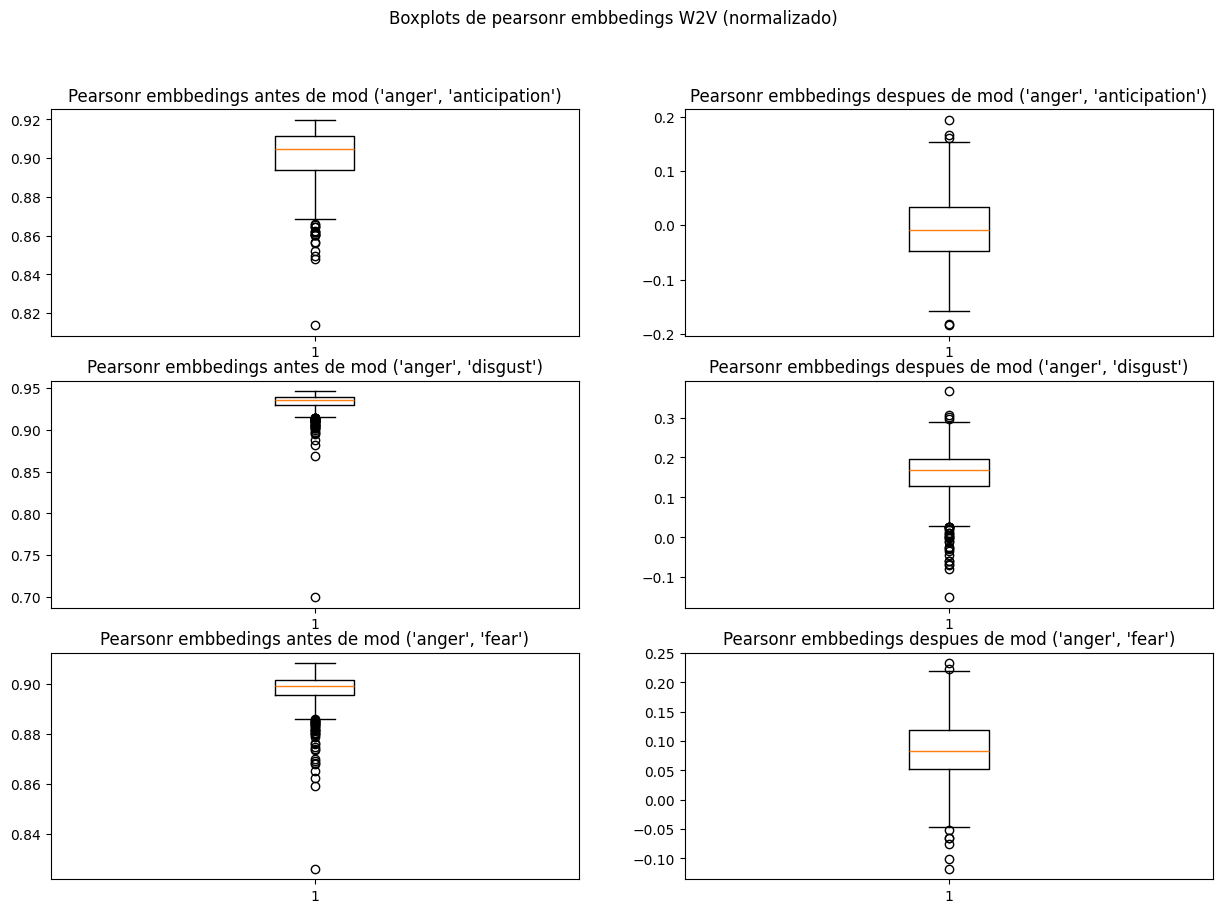

In [35]:
fig,ax = plt.subplots(3,2,figsize=(15,10))

fig.suptitle("Boxplots de pearsonr embbedings W2V (normalizado)")
for i in range(3):
    comb = emotion_combinations[i]
    ax[i,0].set_title("Pearsonr embbedings antes de mod "+str(comb))
    ax[i,0].boxplot(pearsonr_data_w2v[comb])

    ax[i,1].set_title("Pearsonr embbedings despues de mod "+str(comb))
    ax[i,1].boxplot(pearsonr_mod_data_w2v[comb])
plt.show()

## Análisis de impacto en la sémantica.

In [36]:
# Samples per second
sps = 100

# Duration
duration_s = 1.0

# ac: amplitude of the carrier. Should be kept at 1.0 in this script
# you would modify it if you were micing it with, or modulating other,
# waveforms.

# carrier_hz: Frequency of the carrier
# fm_hz: Frequency of the frequency modulator
# k_p: deviation constant
carrier_amplitude = 1.0
carrier_hz = 3.0
fm_hz = 50.0
k = 50

each_sample_number = np.arange(duration_s * sps)
carrier = 2 * np.pi * each_sample_number * carrier_hz / sps

words_modembed_w2v = {}
words_modembed_fst = {}

for emotion in emotion_list:

    words_modembed_w2v[emotion] = {}
    words_modembed_fst[emotion] = {}

    words_w2v = poems_w2v[emotion].wv.key_to_index.keys()
    words_fst = poems_fst[emotion].wv.key_to_index.keys()

    for word in words_w2v:

        embbeding = poems_w2v[emotion].wv.get_vector(word,norm=True)

        fm_embbed = np.cos(carrier + k*embbeding)
        fm_embbed = fm_embbed / np.sqrt(np.sum(fm_embbed**2))

        words_modembed_w2v[emotion][word] = fm_embbed
    
    for word in words_fst:

        embbeding = poems_fst[emotion].wv.get_vector(word,norm=True)

        fm_embbed = np.cos(carrier + k*embbeding)
        fm_embbed = fm_embbed / np.sqrt(np.sum(fm_embbed**2))

        words_modembed_fst[emotion][word] = fm_embbed

In [37]:
#Similitud coseno
from sklearn.metrics.pairwise import cosine_similarity

def similarity(element1,element2):
    return 1 - cosine_similarity([element1],[element2])[0]
     

In [38]:
#Modelo KNNNeighbours
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

KNC_w2v = NearestNeighbors(n_neighbors=5,metric=similarity,algorithm="ball_tree")
KNC_fst = NearestNeighbors(n_neighbors=5,metric=similarity)

emotion = "anger"
w2v_modembbed = [vector for word,vector in words_modembed_w2v[emotion].items()]
fst_modembbed = [vector for word,vector in words_modembed_fst[emotion].items()]

KNC_w2v.fit(w2v_modembbed)
KNC_fst.fit(fst_modembbed)

NearestNeighbors(metric=<function similarity at 0x7febdd593ec0>)

In [39]:
w2v_embbed_word = {tuple(vector):word for word,vector in words_modembed_w2v[emotion].items()}
fst_embbed_word = {tuple(vector):word for word,vector in words_modembed_fst[emotion].items()}

In [40]:
word = "among"
embbeding = poems_w2v[emotion].wv.get_vector(word,norm=True)
fm_embbed = np.cos(carrier + k*embbeding)
fm_embbed = fm_embbed / np.sqrt(np.sum(fm_embbed**2))

neigh = KNC_w2v.kneighbors([fm_embbed],n_neighbors=6,return_distance=True)
print(neigh)
for idx in neigh[1][0]:
    word = w2v_modembbed[idx]
    word = w2v_embbed_word[tuple(word)]
    print(word)

(array([[-2.22044605e-16,  7.96523489e-03,  8.38512229e-03,
         8.98021547e-03,  9.11432857e-03,  9.25985097e-03]]), array([[321,  54,  52,  12,  47,  50]]))
among
where
our
on
them
out


In [41]:
poems_w2v[emotion].wv.most_similar("among",topn=5)

[('where', 0.9996017217636108),
 ('on', 0.9995723366737366),
 ('thy', 0.9995706081390381),
 ('our', 0.9995667934417725),
 ('by', 0.9995629191398621)]

In [1]:
def jaccard_distance(A, B):
    intersection = len(A.intersection(B))
    union = len(A.union(B))
    return 1 - intersection / union

jacard_ind = {}
words = poems_w2v[emotion].wv.key_to_index.keys()

for emotion in emotion_list:

    jacard_ind[emotion] = {}
    jacard_ind[emotion]["w2v"] = []
    jacard_ind[emotion]["fst"] = []

    words = list(poems_w2v[emotion].wv.key_to_index.keys())
    
    w2v_modembbed_ = [vector for word,vector in words_modembed_w2v[emotion].items()]
    fst_modembbed_ = [vector for word,vector in words_modembed_fst[emotion].items()]

    w2v_embbed_word_ = {tuple(vector):word for word,vector in words_modembed_w2v[emotion].items()}
    fst_embbed_word_ = {tuple(vector):word for word,vector in words_modembed_fst[emotion].items()}

    NNw2v = NearestNeighbors(n_neighbors=6,metric=similarity)
    NNfst = NearestNeighbors(n_neighbors=6,metric=similarity)

    NNw2v.fit(w2v_modembbed_)
    NNfst.fit(fst_modembbed_)

    for word in words:
        neigh_w2v = NNw2v.kneighbors([words_modembed_w2v[emotion][word]],n_neighbors=6,return_distance=False)
        neigh_fst = NNfst.kneighbors([words_modembed_fst[emotion][word]],n_neighbors=6,return_distance=False)
        
        mod_w2v_set = set()
        for idx in neigh_w2v[0]:
            word_ = w2v_modembbed_[idx]
            word_ = w2v_embbed_word_[tuple(word_)]
            mod_w2v_set.add(word_)
        mod_w2v_set = mod_w2v_set - set([word])

        mod_fst_set = set()
        for idx in neigh_fst[0]:
            word_ = fst_modembbed_[idx]
            word_ = fst_embbed_word_[tuple(word_)]
            mod_fst_set.add(word_)
        mod_fst_set = mod_fst_set - set([word])

        w2v_similar = poems_w2v[emotion].wv.most_similar(word,topn=5)
        fst_similar = poems_fst[emotion].wv.most_similar(word,topn=5)

        fst_set = set()
        w2v_set = set()

        for i in range(5):
            w2v_set.add(w2v_similar[i][0])
            fst_set.add(fst_similar[i][0])
        
        jacard_ind[emotion]["w2v"].append(jaccard_distance(w2v_set,mod_w2v_set))
        jacard_ind[emotion]["fst"].append(jaccard_distance(fst_set,mod_fst_set))

jacard_ind = pd.DataFrame(jacard_ind)
jacard_ind

NameError: name 'poems_w2v' is not defined

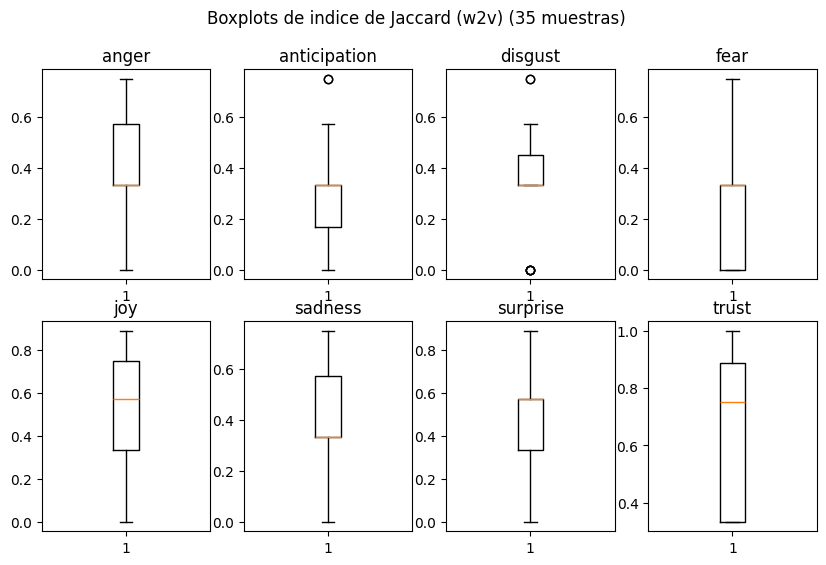

In [ ]:
from itertools import product

fig,ax = plt.subplots(2,4,figsize=(10,6))
fig.suptitle("Boxplots de indice de Jaccard (w2v) (35 muestras)")
for element in zip(product(range(2),range(4)),jacard_ind.columns):
    ax[element[0][0],element[0][1]].set_title(element[1])
    ax[element[0][0],element[0][1]].boxplot(jacard_ind[element[1]]["w2v"])
plt.show()

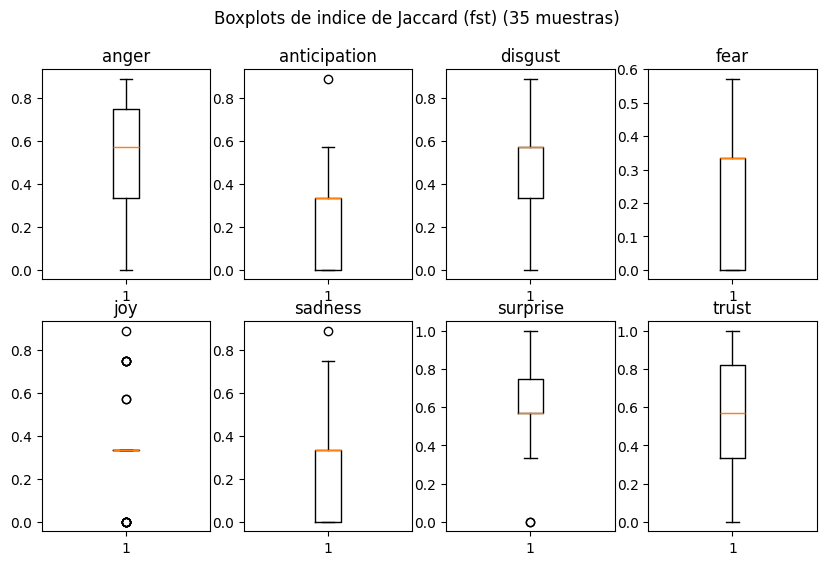

In [ ]:
fig,ax = plt.subplots(2,4,figsize=(10,6))
fig.suptitle("Boxplots de indice de Jaccard (fst) (35 muestras)")
for element in zip(product(range(2),range(4)),jacard_ind.columns):
    ax[element[0][0],element[0][1]].set_title(element[1])
    ax[element[0][0],element[0][1]].boxplot(jacard_ind[element[1]]["fst"])
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x7f45440c9c50>,
 'caps': [<matplotlib.lines.Line2D at 0x7f453e9f1090>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f453e79e710>],
 'medians': [<matplotlib.lines.Line2D at 0x7f453e9f2e90>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f453e9f3bd0>],
 'means': []}

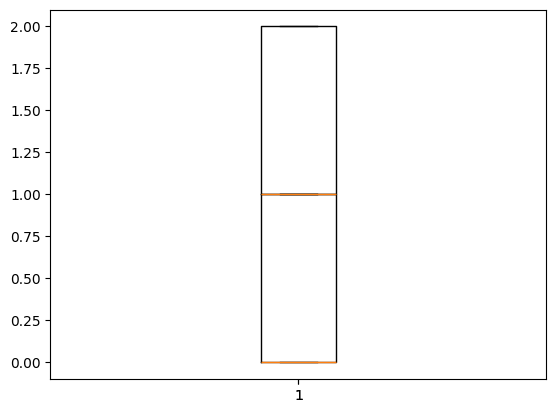

In [ ]:
x1 = [1,1,1,1,2,1,2,1,2]
x2 = [0,0,0,1,0,0,1,0,1]
fig,ax = plt.subplots()

ax.boxplot(x1)
ax.boxplot(x2)
